# ライブラリのインポートと基本設定

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ハイパーパラメータの設定
img_rows = 28
img_cols = 28
channels = 1
img_shape = (channels, img_rows, img_cols) # PyTorchは (C, H, W) 形式
z_dim = 100 # Latent Space（潜在空間）の次元数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator（生成器）の定義

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            # Fully Connected Layer（全結合層）
            nn.Linear(z_dim, 128),
            # Leaky ReLU Activation
            nn.LeakyReLU(0.01, inplace=True),
            # Output Layer
            nn.Linear(128, int(np.prod(img_shape))),
            # Tanh Activation（出力を[-1, 1]の範囲に収める）
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        # 1次元の出力を画像サイズ (Channels, Height, Width) に変形
        img = img.view(img.size(0), *self.img_shape)
        return img

# Discriminator（識別器）の定義

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Flatten（画像を1次元ベクトルに変換）
            nn.Flatten(),
            # Fully Connected Layer
            nn.Linear(int(np.prod(img_shape)), 128),
            # Leaky ReLU Activation
            nn.LeakyReLU(0.01, inplace=True),
            # Output Layer
            nn.Linear(128, 1),
            # Sigmoid Activation（[0, 1]の確率値として出力）
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# モデルの構築と最適化アルゴリズムの設定

In [4]:
# インスタンス化
generator = Generator(z_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# 損失関数: Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer（最適化アルゴリズム）: Adam
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 学習ループ

0 [D loss: 0.7287] [G loss: 0.7183]


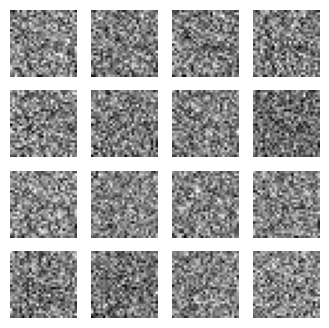

Saved model checkpoints at iteration 0
1000 [D loss: 0.4318] [G loss: 0.9891]


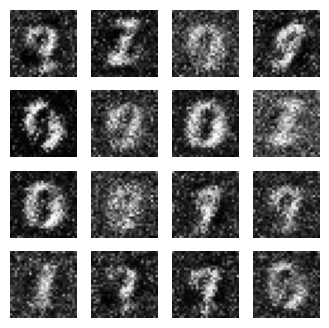

Saved model checkpoints at iteration 1000


In [ ]:
def train(iterations, batch_size, sample_interval):
    # 保存用ディレクトリの作成（なければ作る）
    os.makedirs("checkpoints", exist_ok=True)

    # MNISTデータの読み込みと前処理 ([-1, 1]に正規化)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataloader = DataLoader(
        datasets.MNIST('.', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True
    )

    losses = []
    iteration_checkpoints = []

    # イテレータの作成
    data_iter = iter(dataloader)

    for iteration in range(iterations+1):
        
        # --- データの準備 ---
        try:
            real_imgs, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            real_imgs, _ = next(data_iter)

        real_imgs = real_imgs.to(device)
        # 教師ラベル: 本物は1, 偽物は0
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        #  Train Discriminator
        # -------------------------
        optimizer_D.zero_grad()

        # 本物の画像の判定
        d_loss_real = criterion(discriminator(real_imgs), valid)
        
        # 偽物の画像の生成と判定
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z)
        d_loss_fake = criterion(discriminator(gen_imgs.detach()), fake)

        # 誤差逆伝播と更新
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # 偽物を「本物(1)」と判定させることが目標
        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Progress Logging & Saving
        # ---------------------
        if (iteration) % sample_interval == 0:
            print(f"{iteration} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            losses.append((d_loss.item(), g_loss.item()))
            iteration_checkpoints.append(iteration + 1)
            
            # 画像の保存・表示
            sample_images(generator)
            
            # === モデルの保存処理 (ここを追加) ===
            # GeneratorとDiscriminatorの重みをそれぞれ保存
            torch.save(generator.state_dict(), f"checkpoints/generator_{iteration}.pth")
            torch.save(discriminator.state_dict(), f"checkpoints/discriminator_{iteration}.pth")
            print(f"Saved model checkpoints at iteration {iteration}")
            
    return np.array(losses), iteration_checkpoints

# sample_images関数などはそのまま変更なしでOK

def sample_images(generator, rows=4, cols=4):
    generator.eval()
    z = torch.randn(rows * cols, z_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = 0.5 * gen_imgs + 0.5 # [-1, 1] -> [0, 1]

    fig, axs = plt.subplots(rows, cols, figsize=(4, 4))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# 実行
losses, checkpoints = train(iterations=10000, batch_size=128, sample_interval=1000)

# 学習済み生成器の読み込みと画像生成

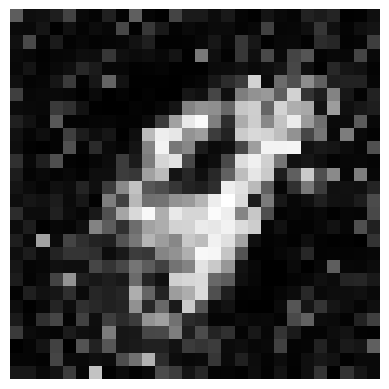

In [ ]:
# --- 設定 ---
# 読み込みたいモデルのパス（保存したファイル名を指定してください）
checkpoint_path = "checkpoints/generator_10000.pth" 

# --- 1. モデルの枠組みを用意して、重みをロード ---
# まずモデルの構造（箱）を作ります
generator = Generator(z_dim, img_shape).to(device)

# 指定したパスから重み（中身）を読み込みます
# map_location=device をつけることで、GPUで保存したモデルをCPUでも開けるようにします
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))

# --- 2. Generatorで画像を生成 ---
generator.eval() # 推論モードへ（BatchNormなどを固定）

# ランダムなノイズを1つ作成 (バッチサイズ=1, 次元=100)
z = torch.randn(1, z_dim).to(device)

with torch.no_grad(): # 勾配計算をしない（メモリ節約）
    gen_img = generator(z)

# --- 3. 表示用に整形 ---
# (1, 1, 28, 28) -> (28, 28) に不要な次元を削除してNumpy化
image = gen_img.squeeze().cpu().numpy()

# 画素値を [-1, 1] から [0, 1] に戻す
image = 0.5 * image + 0.5

# --- 4. 表示 ---
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
gen_img.squeeze().shape

torch.Size([28, 28])